# Chronos

In [1]:
import polars as pl
import chronos
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 3)
plt.rcParams["figure.constrained_layout.use"] = True

In [2]:
df = pl.read_csv("data/preproc/train.csv", try_parse_dates=True)
df = df.drop("id", "city", "state", "store_type", "store_cluster")

dates = df["date"].unique(maintain_order=True)

Select a single store to use for evaluation and split the data into training and validation set, with the validation set having the same length as the actual target.

In [ ]:
df = df.filter(store_nbr=1)

train_df = df.filter(pl.col("date").is_in(dates.head(-16).implode()))
valid_df = df.filter(pl.col("date").is_in(dates.tail(16).implode()))

Load the model and predict all series.

In [ ]:
pipeline = chronos.Chronos2Pipeline.from_pretrained("amazon/chronos-2")

predt_df = pl.from_pandas(
    pipeline.predict_df(
        train_df.to_pandas(),
        future_df=valid_df.drop("sales").to_pandas(),
        prediction_length=16,
        quantile_levels=[0.1, 0.5, 0.9],
        id_column="series_id",
        timestamp_column="date",
        target="sales",
    )
)

predt_df = predt_df.cast({"date": pl.Date})

In [10]:
def plot_series_predictions(
    train_df: pl.DataFrame,
    valid_df: pl.DataFrame,
    predt_df: pl.DataFrame,
    series_id: int,
    context_len: int = 30,
):
    tdf = train_df.filter(series_id=series_id).tail(context_len)
    vdf = valid_df.filter(series_id=series_id)
    pdf = predt_df.filter(series_id=series_id)

    _, ax = plt.subplots()

    ax.plot(tdf["date"], tdf["sales"], label="historical data", color="xkcd:azure")
    ax.plot(vdf["date"], vdf["sales"], label="target", color="xkcd:grass green")
    ax.plot(vdf["date"], pdf["predictions"], label="forecast", color="xkcd:violet")
    ax.fill_between(
        pdf["date"], pdf["0.1"], pdf["0.9"], alpha=0.6, color="xkcd:light lavender"
    )

    ax.legend(loc="lower left")
    return ax

Plot the forecast for `family="GROCERY I"`. This is one of the easier families and we see that the forecast matches the actual values closely.

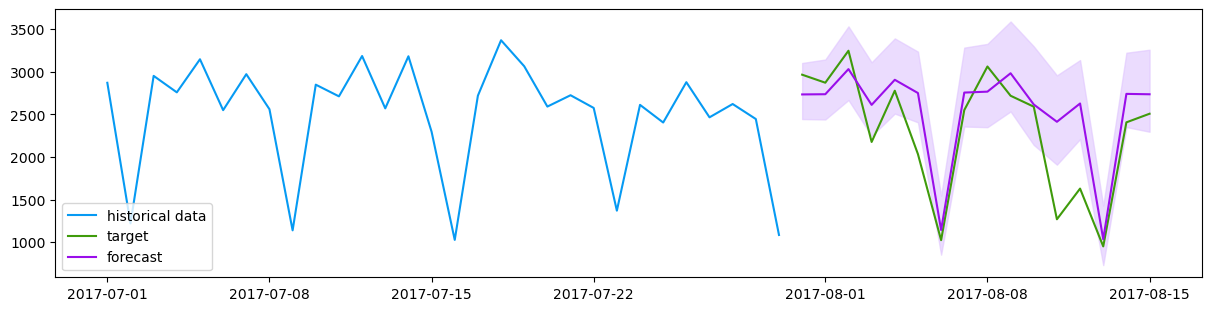

In [11]:
_ = plot_series_predictions(train_df, valid_df, predt_df, 12)

Compute the loss (RMSLE) for the entire validation set.
The loss is about 0.1 lower that that of Prophet on the same validation set.

In [12]:
loss_df = predt_df.join(valid_df, on=["date", "series_id"]).with_columns(
    SLE=(((1 + pl.col("predictions")).log() - (1 + pl.col("sales")).log()) ** 2)
)

loss = loss_df.select(pl.col("SLE").mean().sqrt()).item()
print(f"valid RMSLE: {loss:.3f}")

valid RMSLE: 0.401


Plot loss per family (still for a single store).
Not only is the overall loss lower than that of the Prophet models, we also see that most series are significantly below the overall loss.
The worst-performing series however is significantly worse than that of Prophet, thus raising the overall loss.

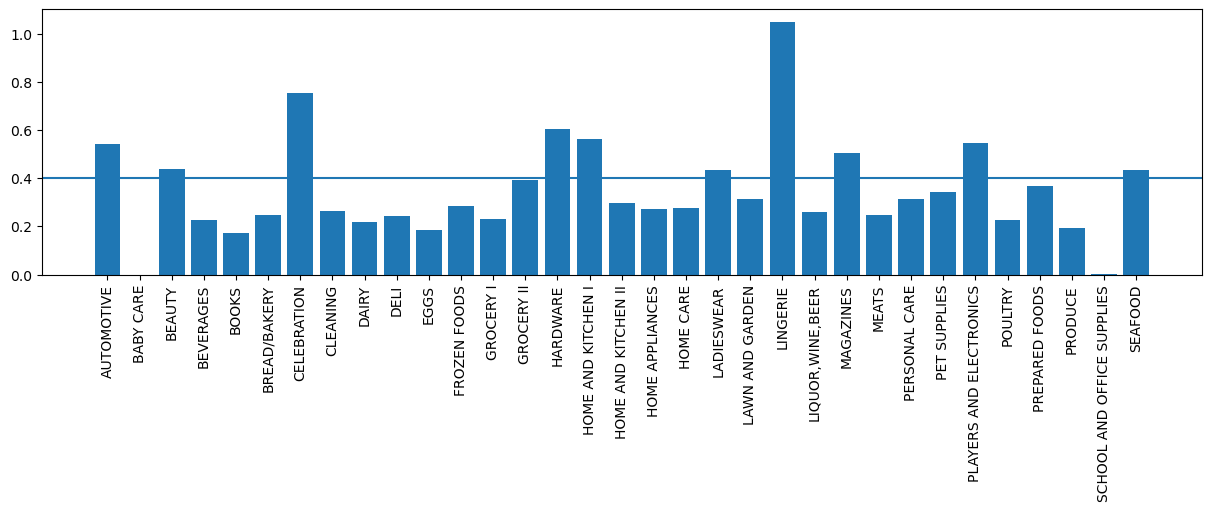

In [13]:
series_loss = loss_df.group_by(["store_nbr", "family"], maintain_order=True).agg(
    pl.col("SLE").mean().sqrt().alias("RMSLE")
)

_, ax = plt.subplots(figsize=(12, 5))
plt.bar(series_loss["family"], series_loss["RMSLE"])
ax.set_xticks(series_loss["family"], series_loss["family"], rotation=90)
ax.axhline(loss)
plt.show()

Plot the forecast for the worst-performing family ("LINGERIE").

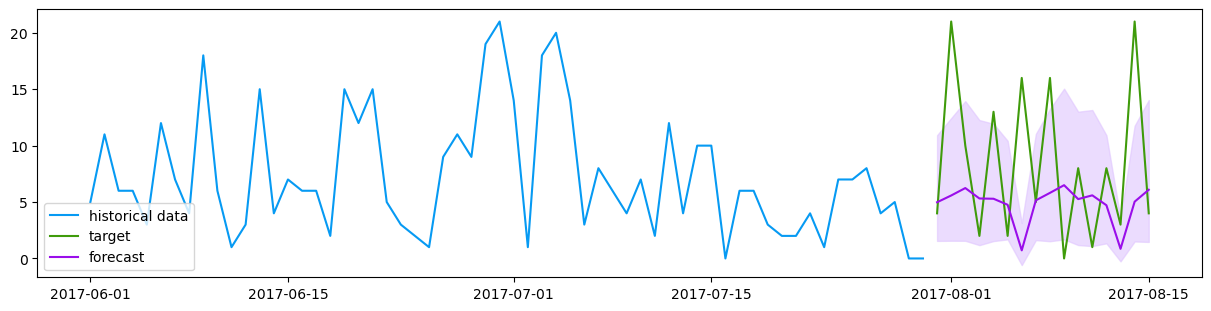

In [14]:
_ = plot_series_predictions(train_df, valid_df, predt_df, 21, context_len=60)